In [1]:
LOACL_RUN = False #@param {type:"boolean"}
if LOACL_RUN:
  PROJECT_ROOT = r"C:\Users\Mohamed\Downloads\Datasets\PanNuke"
else:
  PROJECT_ROOT = r"/content/data"

In [2]:
import os
import cv2
import glob
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [3]:
metadata = {
    "Adrenal-gland": 437,
    "Bile-duct": 420,
    "Bladder": 146,
    "Breast": 2351,
    "Cervix": 293,
    "Colon": 1440,
    "Esophagus": 424,
    "HeadNeck": 384,
    "Kidney": 134,
    "Liver": 224,
    "Lung": 184,
    "Ovarian": 146,
    "Pancreatic": 195,
    "Prostate": 182,
    "Skin": 187,
    "Stomach": 146,
    "Testis": 196,
    "Thyroid": 226,
    "Uterus": 186
}
masksLabels = [
    'Neoplastic cells',
    'Inflammatory',
    'Connective/Soft tissue cells',
    'Dead Cells',
    'Epithelial',
    'Background'
]
numClasses = len(masksLabels)

In [4]:
# @title Meta-Data of the Clients
import pandas as pd

pd.DataFrame({
    'Client 1': ['Adrenal-gland', 'Bile-duct', 'Bladder', 'Breast', 'Cervix', '3647'],
    'Client 2': ['Colon', 'Esophagus', 'HeadNeck', 'Kidney', 'Liver', '2606'],
    'Client 3': ['Lung', 'Ovarian', 'Pancreatic', 'Prostate', 'Skin', '894'],
    'Client 4': ['Stomach', 'Testis', 'Thyroid', 'Uterus','-', '754'],
},index=['#1', '#2', '#3', '#4', '#5', 'Number of samples'])

,Client 1,Client 2,Client 3,Client 4
#1,Adrenal-gland,Colon,Lung,Stomach
#2,Bile-duct,Esophagus,Ovarian,Testis
#3,Bladder,HeadNeck,Pancreatic,Thyroid
#4,Breast,Kidney,Prostate,Uterus
#5,Cervix,Liver,Skin,-
Number of samples,3647,2606,894,754


# Preparing 19 category dataset

In [5]:
! rm -r /content/data
! rm -r /content/sample_data

rm: cannot remove '/content/data': No such file or directory


In [6]:
if not os.path.exists(PROJECT_ROOT):

  # Adrenal gland dataset
  !gdown 1059CuhjnDyM6vw3OZyIbse_SZl7J6jkz

  # # Bile duct dataset
  # !gdown 1-QAxz5lGqWKR83wXjTaGzLzpEEy6yU_O

  # # Bladder dataset
  # !gdown 10GGnkhf17x-jybzByGidrB3FhlAoqLiy

  # # Breast dataset
  # !gdown 1-QnqgAYXCgkrDh2z5iNkpGNFPcmbzbZi

  # # Cervix dataset
  # !gdown 10E2NlmzPIgL3HQNMJFX-RNpdF-g5CIco

  # # Colon dataset
  # !gdown 103oe546kn9bxXYBDjaEP1WIaZ2OFN_D2

  # # Esophagus dataset
  # !gdown 105yk6GoXEAwLOAyMQPPB3_wKkemjfwk4

  # # Head and Neck dataset
  # !gdown 1-w2qawmkQFzGcquVPuhagzK0n2WIn_8a

  # # Kidney dataset
  # !gdown 10AqaaV2XimzbIjoB5Rb6dl0fHdLCIXNo

  # # Liver dataset
  # !gdown 1-bXMi9RBdRts1n39C_-D2Igvqh7PsJSG

  # # Lung dataset
  # !gdown 1-XYhanJIp7rJiLVTJRD-javgxOUDrT-q

  # # Ovarian dataset
  # !gdown 1-YVd5JXuKJle3WP-Q3yvQvKDQTaLD9LB

  # # Pancreatic dataset
  # !gdown 1-Bjxa4T9LYfmF05Hbu04eHlZIIci6b9u

  # # Prostate dataset
  # !gdown 105wLPCyILojUmz7cjXrQsZ6RA6zmaKQh

  # # Skin dataset
  # !gdown 102gajydy9NnOo_3oVOP6i1oGRUxKhewt

  # # Stomach dataset
  # !gdown 1-xHrJqi6KJ7KTHOyt6Qz9NhT0dv207qA

  # # Testis dataset
  # !gdown 1-qqu3QNMYLnJyQNaBdTBmnGzBuIySTZ7

  # # Thyroid dataset
  # !gdown 1-otLpSzUDWsz0nEbRR-MUPTb_EibGXMb

  # # Uterus dataset
  # !gdown 10EuhTv9w37N8PkGG91ZK2XcaQHQ4E1TH

Downloading...
From: https://drive.google.com/uc?id=1059CuhjnDyM6vw3OZyIbse_SZl7J6jkz
To: /content/Adrenal-gland.zip
100% 63.8M/63.8M [00:02<00:00, 23.8MB/s]


> # Generating Clients

In [7]:
def divide_datasets(*, datasets: list[str], num_clients: int) -> dict:
  '''
  Divide a list of datasets evenly among a specified number of clients.

  Parameters:
  - datasets (list[str]): A list of dataset names or identifiers to be divided.
  - num_clients (int): The number of clients to distribute the datasets to.

  Returns:
  - client_datasets (dict): A dictionary where keys are client identifiers (e.g., 'client 1', 'client 2') and
    values are lists containing the datasets assigned to each client.

  Example:
  >>> datasets = ['data1', 'data2', 'data3', 'data4', 'dcata5']
  >>> divided_datasets = divide_datasets(datasets=datasets, num_clients=3)
  >>> print(divided_datasets)
  {'client 1': ['data1', 'data2'], 'client 2': ['data3', 'data4'], 'client 3': ['data5']}

  This function evenly distributes the provided datasets among the specified number of clients,
  taking into account any remaining datasets that cannot be evenly divided.

  Note: The order of the datasets in the input list will be preserved as closely as possible.
  '''
  # Calculate the number of datasets per client and the remainder
  num_datasets = len(datasets)
  datasets_per_client = num_datasets // num_clients
  remainder = num_datasets % num_clients

  # Initialize the output dictionary
  client_datasets: dict = {}

  # Distribute datasets to clients
  start_idx = 0
  for client_id in range(1, num_clients + 1):
    end_idx = start_idx + datasets_per_client + (1 if client_id <= remainder else 0)
    client_datasets[f'client {client_id}'] = datasets[start_idx:end_idx]
    start_idx = end_idx

  return client_datasets

In [8]:
from pprint import pprint
categories = sorted(glob.glob("/content/**/*.zip", recursive=True))
categories = [path.split('/')[-1] for path in categories]
num_clients = 4
clients = divide_datasets(datasets = categories , num_clients = num_clients)
pprint(clients)

{'client 1': ['Adrenal-gland.zip'],
 'client 2': [],
 'client 3': [],
 'client 4': []}


> ## Unzipping

In [9]:
category_zip_path = sorted(glob.glob("/content/**/*.zip", recursive=True))

In [10]:
for category_path in tqdm(category_zip_path, total = len(category_zip_path)):
  if not (os.path.exists(PROJECT_ROOT + category_path)):
    ! unzip -n -qq {category_path} -d {PROJECT_ROOT} # unzipping the files to PROJECT_ROOT
    ! rm {category_path} # deleting the .zip files to save space

  0%|          | 0/1 [00:00<?, ?it/s]

> # Data Preprocessing

In [11]:
images = []

# Local Path
image_path_list = glob.glob(r"C:\Users\Mohamed\Downloads\Datasets\PanNuke\**\*.png", recursive=True)

if len(image_path_list) == 0:
  # colab Path
  image_path_list = glob.glob("/content/data/**/*.png", recursive=True)

image_path_list.sort()

for img_path in tqdm(image_path_list , total = len(image_path_list)):
  img = cv2.imread(img_path,1)
  images.append(img)

  0%|          | 0/437 [00:00<?, ?it/s]

In [12]:
images = np.array(images)

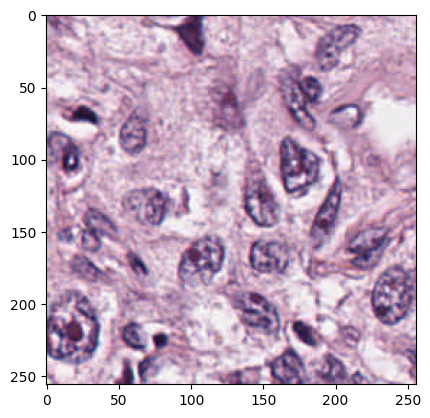

In [13]:
# Display the image
plt.imshow(images[0])
plt.show()

Normalize each image on its own

In [14]:
# normalizedImages = []
# for image in tqdm(images):

#     min_val = image.min()
#     max_val = image.max()

#     normalizedImages = (image - min_val) / (max_val - min_val) + 1e-7

#     normalizedImages.append(normalizedImages)

In [15]:
# images = np.array(normalizedImages)

# del normalizedImages

In [16]:
masks = []

# Local Path
mask_path_list = glob.glob(r"C:\Users\Mohamed\Downloads\Datasets\PanNuke\**\*.npy", recursive=True)

if len(mask_path_list) == 0:
  # colab Path
  mask_path_list = glob.glob("/content/data/**/*.npy", recursive=True)

mask_path_list.sort()
for mask_path in tqdm(mask_path_list, total = len(mask_path_list)):
  mask = np.load(mask_path)
  masks.append(mask)

  0%|          | 0/437 [00:00<?, ?it/s]

In [17]:
masks = np.array(masks)

In [18]:
masks = np.transpose(masks, (0, 2, 3, 1)) #Re-indexing to (num_samples, width, height, channel)

In [19]:
for classIndex in range(numClasses):
  print(f'channel {classIndex}: {masksLabels[classIndex]}') # print the channel num & name
  print(np.unique( # Getting only the unique values
      masks[0,:, :, classIndex])
  )
  print()

channel 0: Neoplastic cells
[  0.   4.  12.  28.  33.  41.  45.  46.  56.  59.  63.  71.  74.  77.
  84.  90.  91.  96.  97. 105. 114. 127. 128. 139. 149. 150. 161.]

channel 1: Inflammatory
[  0. 143.]

channel 2: Connective/Soft tissue cells
[  0. 104. 137. 153. 156. 157. 164.]

channel 3: Dead Cells
[0.]

channel 4: Epithelial
[0.]

channel 5: Background
[0. 1.]



In [52]:
def plotMask(masks, numClasses = numClasses):
  fig, axes = plt.subplots(2, 3, figsize=(10, 6))

  channel_images = []

  for classIndex in range(numClasses):

      max_value = np.max(masks[ :, :, classIndex])

      colors = plt.cm.get_cmap('tab20', int(max_value + 1))

      row = classIndex // 3
      col = classIndex % 3

      ax = axes[row, col]
      im = ax.imshow(masks[ :, :, classIndex], cmap=colors, vmin=0, vmax=max_value)
      ax.set_title(f'Channel {classIndex} : {masksLabels[classIndex]}')
      ax.axis('off')
      channel_images.append(im)

  cbar_ax = fig.add_axes([0.15, -0.02, 0.7, 0.03])
  cbar = fig.colorbar(channel_images[0], cax=cbar_ax, orientation='horizontal')
  plt.tight_layout()
  plt.show()

<ipython-input-52-f07fa9cbb55d>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', int(max_value + 1))
<ipython-input-52-f07fa9cbb55d>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


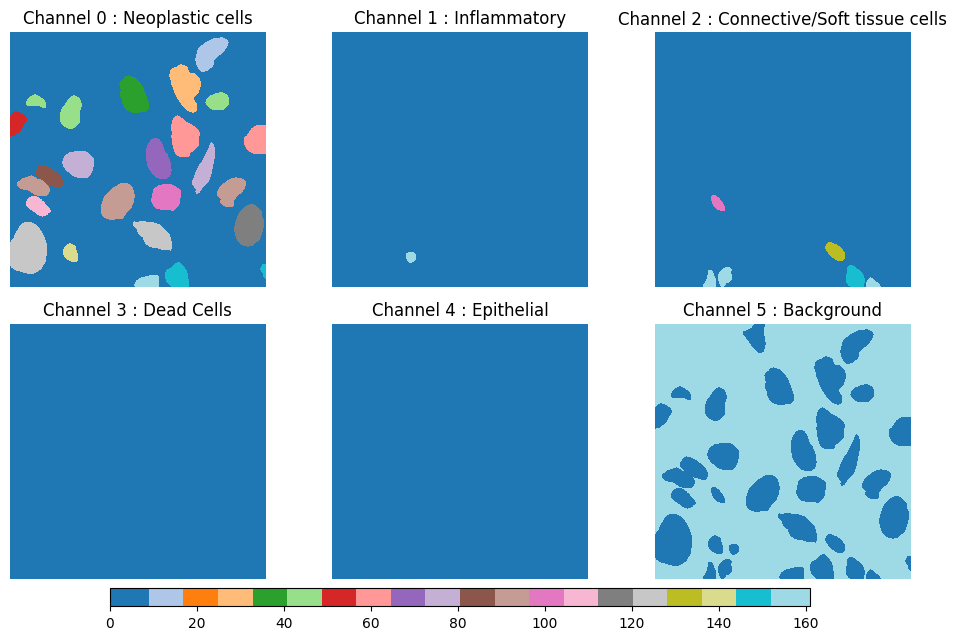

In [53]:
plotMask(masks[0])

In [54]:
def binarizeChannel(masks):

    masksNum, channels, _, _ = masks.shape

    masks_binary = np.empty_like(masks)

    # Loop through each mask and channel
    for mask_idx in tqdm(range(masksNum)):
        for channel_idx in range(channels):

            current_channel = masks[mask_idx, channel_idx]

            # set higher values than 1 to 1
            current_channel[current_channel > 1] = 1

            masks_binary[mask_idx, channel_idx] = current_channel

    return masks_binary

In [55]:
masks = binarizeChannel(masks)

  0%|          | 0/437 [00:00<?, ?it/s]

In [56]:
for classIndex in range(numClasses):
  print(f'channel {classIndex}: {masksLabels[classIndex]}') # print the channel num & name
  print(np.unique( # Getting only the unique values
      masks[0,:, :, classIndex])
  )
  print()

channel 0: Neoplastic cells
[0. 1.]

channel 1: Inflammatory
[0. 1.]

channel 2: Connective/Soft tissue cells
[0. 1.]

channel 3: Dead Cells
[0.]

channel 4: Epithelial
[0.]

channel 5: Background
[0. 1.]



<ipython-input-52-f07fa9cbb55d>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', int(max_value + 1))
<ipython-input-52-f07fa9cbb55d>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


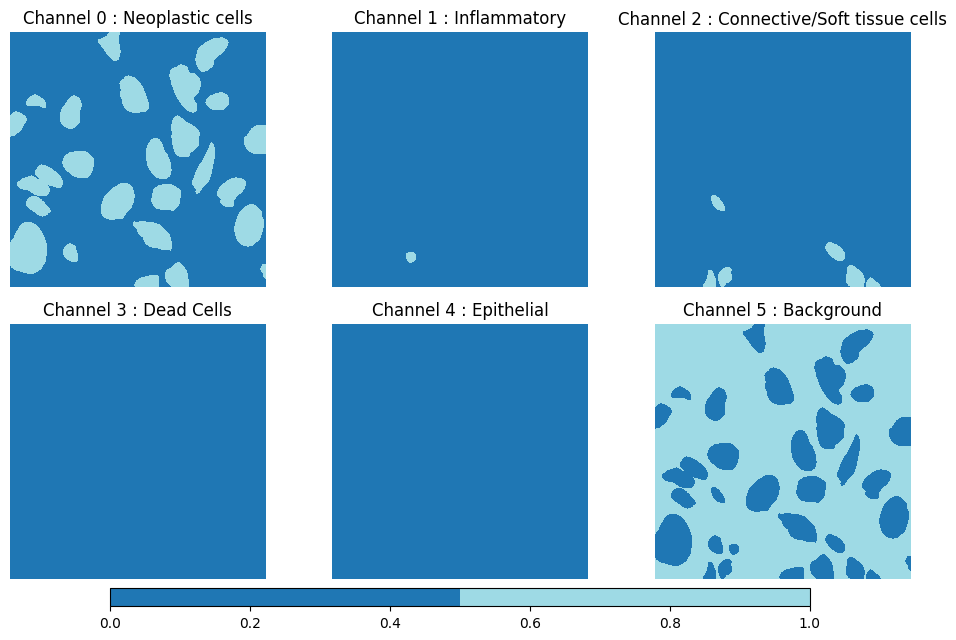

In [57]:
plotMask(masks[0])

In [58]:
masks = np.array(masks, dtype=np.uint8)

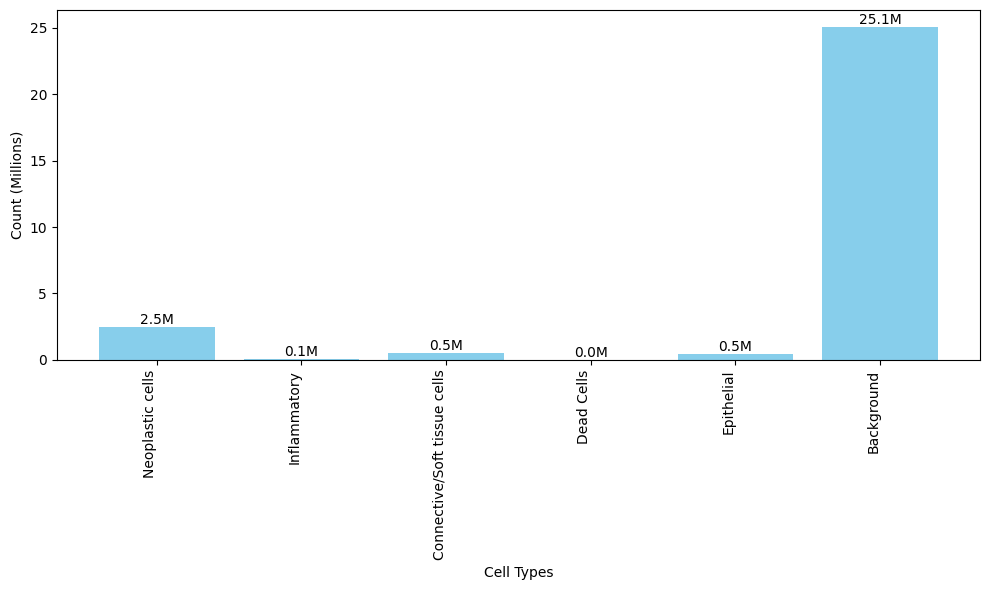

In [59]:
class_frequencies = np.sum(masks, axis=(0, 1, 2))
data_in_millions = [count / 1e6 for count in class_frequencies]

plt.figure(figsize=(10, 6))
bars = plt.bar(masksLabels, data_in_millions, color='skyblue')
plt.xlabel('Cell Types')
plt.ylabel('Count (Millions)')
plt.xticks(rotation=90, ha='right')

# Add counts on top
for bar, count in zip(bars, data_in_millions):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{count:.1f}M',
             ha='center', va='bottom')

plt.tight_layout();

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(images,
                                                    masks,
                                                    test_size=0.2,
                                                    random_state=1)
del images
del masks

In [61]:
# Split the remaining 20% into validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp,
                                                y_temp,
                                                test_size=0.5,  # 0.5 of 20% = 10%
                                                random_state=1)
del X_temp
del y_temp

# Define data augmentation functions

In [62]:
def random_flip(image, mask):
    if np.random.rand() > 0.5:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)
    return image, mask

def random_rotation(image, mask, max_angle=15):
    angle = np.random.uniform(-max_angle, max_angle)
    rows = image.shape[0]
    cols = image.shape[1]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    image = cv2.warpAffine(image, M, (cols, rows), flags=cv2.INTER_LINEAR)
    mask = cv2.warpAffine(mask, M, (cols, rows), flags=cv2.INTER_NEAREST)
    return image, mask

def random_shift(image, mask, max_shift=0.0625):
    rows = image.shape[0]
    cols = image.shape[1]
    max_x = int(max_shift * cols)
    max_y = int(max_shift * rows)
    tx = np.random.uniform(-max_x, max_x)
    ty = np.random.uniform(-max_y, max_y)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    image = cv2.warpAffine(image, M, (cols, rows))
    mask = cv2.warpAffine(mask, M, (cols, rows), flags=cv2.INTER_NEAREST)
    return image, mask

def random_scale(image, mask, max_scale=0.5):
    scale = np.random.uniform(1 - max_scale, 1 + max_scale)
    rows = image.shape[0]
    cols = image.shape[1]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), 0, scale)
    image = cv2.warpAffine(image, M, (cols, rows))
    mask = cv2.warpAffine(mask, M, (cols, rows), flags=cv2.INTER_NEAREST)
    return image, mask

# Appy data augmentation functions

In [63]:
augmented_trainImages = []
augmented_trainMasks = []

for i in tqdm(range(len(X_train))):

    image = X_train[i]
    mask = y_train[i]

    # Apply data augmentation techniques
    image, mask = random_flip(image, mask)
    image, mask = random_rotation(image, mask)
    image, mask = random_shift(image, mask)
    image, mask = random_scale(image, mask)

    augmented_trainImages.append(image)
    augmented_trainMasks.append(mask)

  0%|          | 0/349 [00:00<?, ?it/s]

In [64]:
augmented_trainImages = np.array(augmented_trainImages)
augmented_trainMasks = np.array(augmented_trainMasks)

In [65]:
X_train = np.concatenate([X_train, augmented_trainImages])
y_train = np.concatenate([y_train, augmented_trainMasks])

In [66]:
del augmented_trainImages
del augmented_trainMasks

<ipython-input-52-f07fa9cbb55d>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', int(max_value + 1))
<ipython-input-52-f07fa9cbb55d>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


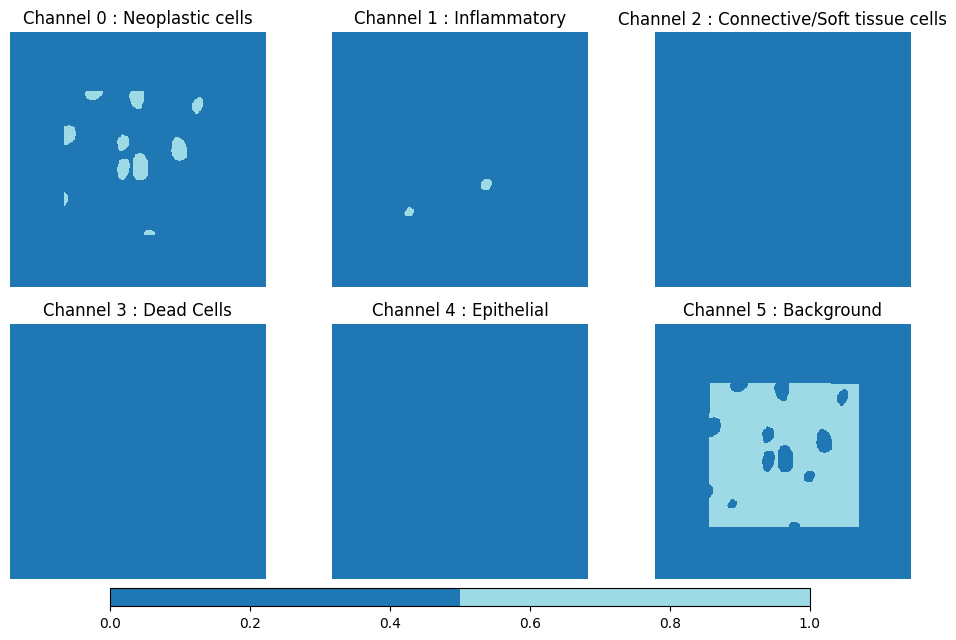

In [69]:
plotMask(y_train[(len(y_train)//2)+1])

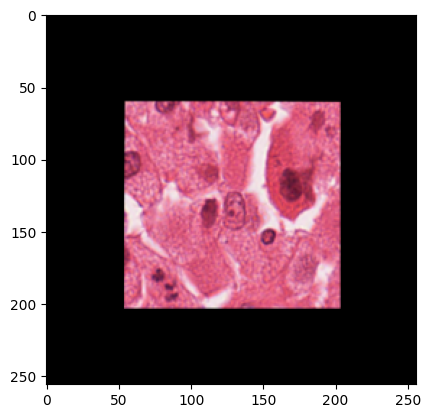

In [70]:
plt.imshow(X_train[(len(X_train)//2)+1])
plt.show()

In [71]:
! pip install pywaffle -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 7.0 MB/s eta 0:00:00


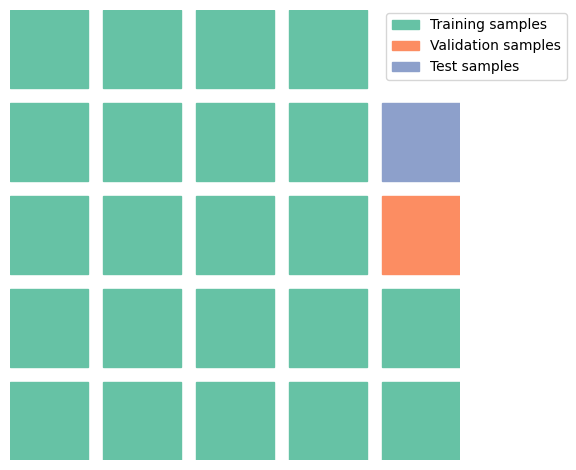

In [37]:
# @title Data Split

from pywaffle import Waffle

value = {'Training samples': len(X_train), 'Validation samples': len(X_val) , 'Test samples': len(X_test)}

# Waffle chart
plt.figure(
    FigureClass = Waffle,
    rows = 5,
    columns = 5,
    values = value,
    legend = {'loc': 'upper left', 'bbox_to_anchor': (0.82, 1.009)})
plt.show()

In [72]:
print("Shape of trainImages:", X_train.shape)
print("Minimum value in trainImages:", X_train.min())
print("Maximum value in trainImages:", X_train.max())
print()
print("Shape of trainMasks:", y_train.shape)
print("Minimum value in trainMasks:", y_train.min())
print("Maximum value in trainMasks:", y_train.max())

Shape of trainImages: (698, 256, 256, 3)
Minimum value in trainImages: 0
Maximum value in trainImages: 255

Shape of trainMasks: (698, 256, 256, 6)
Minimum value in trainMasks: 0
Maximum value in trainMasks: 1


# Test data augmentation functions

In [73]:
class_frequencies = np.sum(y_train, axis=(0, 1, 2))

total_samples = np.sum(class_frequencies)

samples_per_class = class_frequencies / numClasses

class_weights = total_samples / (numClasses * samples_per_class)

In [74]:
import tensorflow as tf

In [75]:
def tversky_coeff(target, prediction, axis=(1, 2, 3), alpha=0.7, beta=0.3, smooth=0.0001):
    """
    Tversky coeff. function for image segmentation.

    Parameters:
    - y_true: Ground truth labels (binary mask).
    - y_pred: Predicted labels (probability mask).
    - axis: Axis or axes along which the Tversky coefficient is computed.
    - alpha: Weight for false positives.
    - beta: Weight for false negatives.
    - smooth: Smoothing factor to avoid division by zero.

    Returns:
    - Tversky coeff.
    """

    # Calculate true positives, false positives, and false negatives
    true_positives = tf.keras.backend.sum(target * prediction, axis=(1, 2, 3))
    false_negatives = tf.keras.backend.sum(target * (1.0 - prediction), axis=(1, 2, 3))
    false_positives = tf.keras.backend.sum((1.0 - target) * prediction, axis=(1, 2, 3))

    # Calculate Tversky coefficient
    tversky_coeff = (true_positives + smooth) / (true_positives + alpha * false_negatives + beta * false_positives + smooth)

    return tversky_coeff

def tversky_loss(target, prediction, axis=(1, 2, 3), alpha=0.7, beta=0.3, smooth=0.0001):
    """
    Tversky loss function for image segmentation.

    Parameters:
    - y_true: Ground truth labels (binary mask).
    - y_pred: Predicted labels (probability mask).
    - axis: Axis or axes along which the Tversky coefficient is computed.
    - alpha: Weight for false positives.
    - beta: Weight for false negatives.
    - smooth: Smoothing factor to avoid division by zero.

    Returns:
    - Tversky loss
    """
    return tf.constant(1.) - tversky_coeff(target, prediction, axis=(1, 2, 3), alpha=0.7, beta=0.3, smooth=0.0001)

In [76]:
def dice_coeff(target, prediction, axis=(1, 2, 3), smooth=0.0001):
    """
    Dice coeff. function for image segmentation.

    Parameters:
    - y_true: Ground truth labels (binary mask).
    - y_pred: Predicted labels (probability mask).
    - axis: Axis or axes along which the Tversky coefficient is computed.
    - smooth: Smoothing factor to avoid division by zero.

    Returns:
    - Dice coeff.
    """
    prediction = tf.round(prediction)  # Round to 0 or 1

    intersection = tf.keras.backend.sum(target * prediction, axis=axis)
    union = tf.keras.backend.sum(target + prediction, axis=axis)
    numerator = tf.constant(2.) * intersection + smooth
    denominator = union + smooth
    coeff = numerator / denominator

    return tf.reduce_mean(coeff)

def dice_loss(target, prediction, axis=(1, 2, 3), smooth=0.0001):
    return tf.constant(1.) - dice_coeff(target, prediction, axis=(1, 2, 3), smooth=0.0001)

In [43]:
def soft_dice_coeff(target, prediction, axis=(1, 2, 3), smooth=0.0001):

    intersection = tf.keras.backend.sum(target * prediction, axis=axis)
    union = tf.keras.backend.sum(target + prediction, axis=axis)
    numerator = tf.constant(2.) * intersection + smooth
    denominator = union + smooth
    soft_dice_coeff = tf.reduce_mean(numerator / denominator)
    return soft_dice_coeff

In [44]:
def iou(target, prediction, axis=(1, 2, 3), smooth=0.0001):
    intersection = tf.keras.backend.sum(target * prediction, axis=axis)
    union = tf.keras.backend.sum(target + prediction, axis=(1, 2, 3)) - intersection
    iou_value = (intersection + smooth) / (union + smooth)
    return iou_value

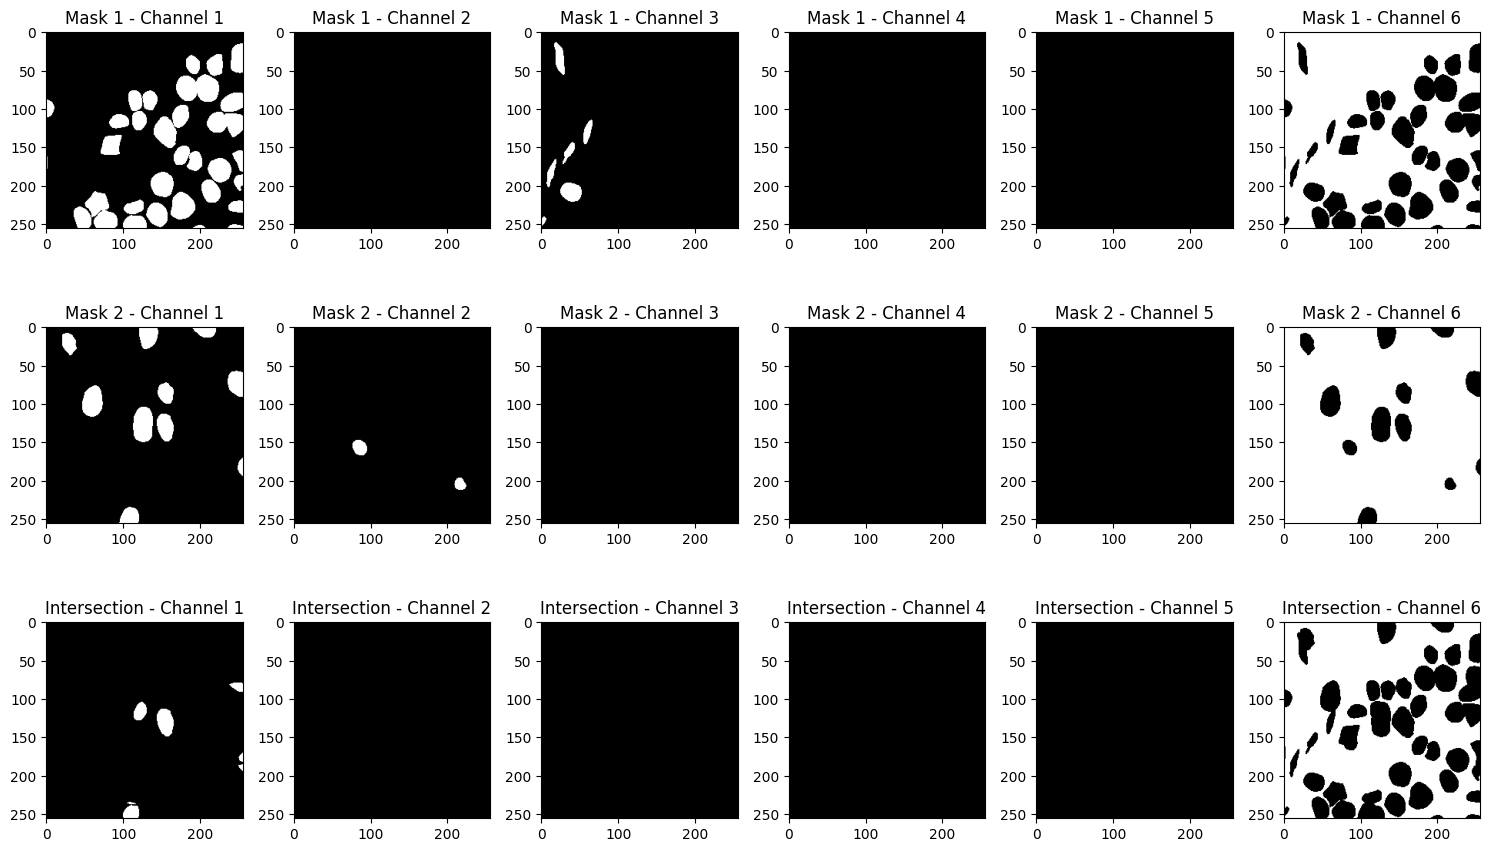

In [45]:
num_masks, width, height, num_channels = y_train.shape
mask1 = y_train[0,:,:,:]
mask2 = y_train[1,:,:,:]

fig, axes = plt.subplots(nrows=3, ncols=num_channels, figsize=(15, 9))

# Plot the first mask channels
for channel in range(num_channels):
    axes[0, channel].imshow(mask1[:, :, channel], cmap='gray')
    axes[0, channel].set_title(f'Mask 1 - Channel {channel + 1}')

# Plot the second mask channels
for channel in range(num_channels):
    axes[1, channel].imshow(mask2[:, :, channel], cmap='gray')
    axes[1, channel].set_title(f'Mask 2 - Channel {channel + 1}')

# Plot the intersection of the two masks
intersection = np.logical_and(mask1, mask2)
for channel in range(num_channels):
    axes[2, channel].imshow(intersection[:, :, channel], cmap='gray')
    axes[2, channel].set_title(f'Intersection - Channel {channel + 1}')

plt.tight_layout()
plt.show()

In [46]:
mask1 = mask1.reshape(1, 256, 256, num_channels)
mask2 = mask2.reshape(1, 256, 256, num_channels)

mask1 = tf.convert_to_tensor(mask1, dtype=tf.float32)
mask2 = tf.convert_to_tensor(mask2, dtype=tf.float32)

In [88]:
def combined_loss(target, prediction, dice_weight = 1/3, focal_weight = 1/3, tversky_weight = 1/3, axis=(1, 2, 3), alpha=0.7, beta=0.3, gamma = 2, smooth=0.0001):

    # Define weights for each loss
    dice_weight = dice_weight
    focal_weight = focal_weight
    tversky_weight = tversky_weight

    # Calculate individual losses
    dice_loss_value = dice_loss(target, prediction, axis=axis, smooth=smooth)
    focal_loss_value = tf.keras.losses.categorical_focal_crossentropy(target, prediction) #alpha = class_weights, gamma = gamma, axis=axis
    focal_loss_value = focal_loss_value/4.02952241897583 # this is the max value the categorical_focal_crossentropy can get
    focal_loss_value = np.mean(focal_loss_value)
    tversky_loss_value = tversky_loss(target, prediction, axis=axis, alpha=alpha, beta=beta, smooth=smooth)

    # Combine losses using weights
    combined_loss_value = (
        dice_weight * dice_loss_value +
        focal_weight * focal_loss_value +
        tversky_weight * tversky_loss_value
    )

    return combined_loss_value

In [48]:
def _dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def _jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def _jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def _dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


In [49]:
ones_tensor = tf.ones_like(mask1)
mask1_inverse = ones_tensor - mask1
mask2 = mask1
mask2 = mask1_inverse

In [50]:
tversky_coeff_value = tversky_coeff(mask1, mask2).numpy()
dice_coef_value = dice_coeff(mask1, mask2).numpy()
soft_dice_coef_value = soft_dice_coeff(mask1, mask2).numpy()
iou_value = iou(mask1, mask2).numpy()
tversky_loss_value = tversky_loss(mask1, mask2).numpy()
dice_loss_value = dice_loss(mask1, mask2).numpy()
categorical_focal_crossentropy_loss = tf.keras.losses.categorical_focal_crossentropy(mask1, mask2)
combined_loss_value = combined_loss(mask1, mask2)

In [51]:
print(f"""
{"Coefficient":^40}

Tversky Coefficient:    {tversky_coeff_value[0]}
Dice Coefficient:       {dice_coef_value}
Soft Dice Coefficient:  {soft_dice_coef_value}
IoU Coefficient:        {iou_value[0]}

{"Losses":^40}
Focal Crossentropy Loss            {np.mean(categorical_focal_crossentropy_loss)}{"-"*10}Range from 0 to 4
Normalized Focal Crossentropy Loss {np.mean(categorical_focal_crossentropy_loss)/4}{"-"*10}Range from 0 to 1

Tversky Loss:           {tversky_loss_value[0]}
Dice Loss:              {dice_loss_value}
Combined Loss:          {combined_loss_value[0]}{"-"*8}This is a Pixel Wise loss function, thus takeing the mean to get the loss for all the mask Range from 0 to 2 and after norm. 0 to 1
""")


              Coefficient               

Tversky Coefficient:    6.935813035013894e-10
Dice Coefficient:       2.5431315386903464e-10
Soft Dice Coefficient:  2.5431315386903464e-10
IoU Coefficient:        2.5431315386903464e-10

                 Losses                 
Focal Crossentropy Loss            4.02952241897583----------Range from 0 to 4
Normalized Focal Crossentropy Loss 1.0073806047439575----------Range from 0 to 1

Tversky Loss:           1.0
Dice Loss:              1.0
Combined Loss:          1.0000001192092896--------This is a Pixel Wise loss function, thus takeing the mean to get the loss for all the mask Range from 0 to 2 and after norm. 0 to 1



In [52]:
tversky_coeff_value[0] + tversky_loss_value[0], dice_coef_value + dice_loss_value

(1.0, 1.0)

In [53]:
# Create a callback to collect metrics during training
class MetricsCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.losses = []
        self.accuracies = []
        self.tf_OneHotIoU = []
        self.tf_OneHotMeanIoU = []
        self.tf_MeanIoU = []
        self.iou = []
        self.dice_coeff = []
        self.tversky_coeff = []
        self._jacard_coef = []
        self._dice_coef = []

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs['loss'])
        self.accuracies.append(logs['accuracy'])
        self.tf_OneHotIoU.append(logs['tf_OneHotIoU'])
        self.tf_OneHotMeanIoU.append(logs['tf_OneHotMeanIoU'])
        self.tf_MeanIoU.append(logs['tf_MeanIoU'])
        self.iou.append(logs['iou'])
        self.dice_coeff.append(logs['dice_coeff'])
        self.tversky_coeff.append(logs['tversky_coeff'])
        self._jacard_coef.append(logs['_jacard_coef'])
        self._dice_coef.append(logs['_dice_coef'])

metrics = MetricsCallback()

In [54]:
# @title MODEL
# https://youtu.be/L5iV5BHkMzM
"""

Attention U-net:
https://arxiv.org/pdf/1804.03999.pdf


Note: Batch normalization should be performed over channels after a convolution,
In the following code axis is set to 3 as our inputs are of shape
[None, height, width, channel]. Channel is axis=3.

"""

import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K



'''
A few useful metrics and losses
'''

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


##############################################################
'''
Useful blocks to build Unet

conv - BN - Activation - conv - BN - Activation - Dropout (if enabled)

'''


def conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).

    1. conv - BN - Activation - conv - BN - Activation
                                          - shortcut  - BN - shortcut+BN

    2. conv - BN - Activation - conv - BN
                                     - shortcut  - BN - shortcut+BN - Activation

    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn



def Attention_ResUNet(input_shape, NUM_CLASSES=6, dropout_rate=0.1, batch_norm=True):
    '''
    Rsidual UNet, with attention

    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers

    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('softmax')(conv_final)

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model

In [55]:
model = Attention_ResUNet((256,256,3), NUM_CLASSES=6, dropout_rate=0.1, batch_norm=True)

In [56]:
tf.experimental.numpy.experimental_enable_numpy_behavior()

In [57]:
model.compile(
    optimizer='adam',
    loss = combined_loss,
    # loss = _dice_coef_loss,
    # loss = tf.keras.losses.categorical_focal_crossentropy,
    metrics=[
        _dice_coef,
        _jacard_coef,
        'accuracy',
        tf.keras.metrics.OneHotMeanIoU(
            num_classes=numClasses,
            name = "tf_OneHotMeanIoU",
            ),
        tf.keras.metrics.OneHotIoU(
            num_classes=numClasses,
            target_class_ids = list(range(numClasses)),
            name = "tf_OneHotIoU",
            ),
        tf.keras.metrics.MeanIoU(
            num_classes=numClasses,
            name = "tf_MeanIoU",
            ),
        iou,
        dice_coeff,
        soft_dice_coeff,
        tversky_coeff,
        combined_loss
        ]
)

In [58]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath='model.{epoch:03d}-{tf_OneHotMeanIoU:.5f}.h5'  ,
    monitor='tf_OneHotMeanIoU',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [59]:
history = model.fit(X_train, y_train,
                    batch_size = 4,
                    verbose = 1,
                    epochs = 150,
                    validation_data = (X_val, y_val),
                    validation_freq = 1,
                    shuffle=True,
                    # class_weight = class_weights,
                    callbacks=[
                        metrics,
                        checkpoint,
                        ]
                    )

Epoch 1/150
175/175 [==============================] - ETA: 0s - loss: 0.3378 - _dice_coef: 0.3845 - _jacard_coef: 0.2390 - accuracy: 0.6585 - tf_OneHotMeanIoU: 0.1753 - tf_OneHotIoU: 0.1753 - tf_MeanIoU: 0.4268 - iou: 0.2378 - dice_coeff: 0.6443 - soft_dice_coeff: 0.3775 - tversky_coeff: 0.3885 - combined_loss: 0.3378
Epoch 1: tf_OneHotMeanIoU improved from -inf to 0.17532, saving model to modelTest_min_loss.keras
175/175 [==============================] - 190s 694ms/step - loss: 0.3378 - _dice_coef: 0.3845 - _jacard_coef: 0.2390 - accuracy: 0.6585 - tf_OneHotMeanIoU: 0.1753 - tf_OneHotIoU: 0.1753 - tf_MeanIoU: 0.4268 - iou: 0.2378 - dice_coeff: 0.6443 - soft_dice_coeff: 0.3775 - tversky_coeff: 0.3885 - combined_loss: 0.3378 - val_loss: 0.2736 - val__dice_coef: 0.5350 - val__jacard_coef: 0.3736 - val_accuracy: 0.6936 - val_tf_OneHotMeanIoU: 0.1591 - val_tf_OneHotIoU: 0.1591 - val_tf_MeanIoU: 0.4167 - val_iou: 0.3842 - val_dice_coeff: 0.7022 - val_soft_dice_coeff: 0.5350 - val_tversky_

In [97]:
model.save("/content/modelTest_min_loss.keras")
from tensorflow.keras.models import load_model

In [100]:
model = load_model("/content/modelTest_min_loss.keras",
                    safe_mode=False,
                    custom_objects={
                        'combined_loss': combined_loss,
                        "_dice_coef" : _dice_coef,
                        "_jacard_coef" : _jacard_coef,
                        "iou" : iou,
                        "dice_coeff" : dice_coeff,
                        "soft_dice_coeff" : soft_dice_coeff,
                        "tversky_coeff" : tversky_coeff,
                        }
                    )

In [104]:
trainResults = model.evaluate(X_train[:4000], y_train[:4000], batch_size=1, verbose=1)

try:
    trainResults2 = model.evaluate(X_train[4000:], y_train[4000:], batch_size=1, verbose=1)
except:
    trainResults2 = None

if trainResults2 is not None:
    trainResults = np.mean([trainResults, trainResults2], axis=0)
else:
    trainResults = trainResults


698/698 [==============================] - 33s 47ms/step - loss: 0.0521 - _dice_coef: 0.9097 - _jacard_coef: 0.8678 - accuracy: 0.9096 - tf_OneHotMeanIoU: 0.4746 - tf_OneHotIoU: 0.4746 - tf_MeanIoU: 0.4275 - iou: 0.8678 - dice_coeff: 0.9115 - soft_dice_coeff: 0.9097 - tversky_coeff: 0.9331 - combined_loss: 0.0521


In [61]:
valResults = model.evaluate(X_val, y_val, batch_size = 1, verbose=1)
testResults = model.evaluate(X_test, y_test, batch_size = 1, verbose=1)

44/44 [==============================] - 2s 50ms/step - loss: 0.0521 - _dice_coef: 0.9381 - _jacard_coef: 0.8854 - accuracy: 0.9383 - tf_OneHotMeanIoU: 0.4810 - tf_OneHotIoU: 0.4810 - tf_MeanIoU: 0.4168 - iou: 0.8854 - dice_coeff: 0.9383 - soft_dice_coeff: 0.9381 - tversky_coeff: 0.9381 - combined_loss: 0.0521


In [62]:
print("Training Results:")
print(f"- Loss: {trainResults[0]:.4f}")
print(f"- YouTube Dice Coefficient: {trainResults[1] * 100:.4f}")
print(f"- YouTube Jacard Coefficient: {trainResults[2] * 100:.4f}")
print(f"- Accuracy: {trainResults[3] * 100:.2f}%")

print(f"- TensorFlow One Hot Mean IoU: {trainResults[4] * 100:.2f}%")
print(f"- TensorFlow One Hot IoU: {trainResults[5] * 100:.2f}%")
print(f"- TensorFlow Mean IoU: {trainResults[6] * 100:.2f}%")

print(f"- IOU: {trainResults[7] * 100:.2f}%")
print(f"- Dice Coefficient: {trainResults[8] * 100:.4f}")
print(f"- Soft Dice Coefficient: {trainResults[9] * 100:.4f}")
print(f"- Tversky Coefficient: {trainResults[10] * 100:.4f}")
print(f"- Combined Loss: {trainResults[11]:.4f}")

print()
print("*"*50)
print()
print("Validation Results:")
print(f"- Loss: {valResults[0]:.4f}")
print(f"- YouTube Dice Coefficient: {valResults[1] * 100:.4f}")
print(f"- YouTube Jacard Coefficient: {valResults[2] * 100:.4f}")
print(f"- Accuracy: {valResults[3] * 100:.2f}%")

print(f"- TensorFlow One Hot Mean IoU: {valResults[4] * 100:.2f}%")
print(f"- TensorFlow One Hot IoU: {valResults[5] * 100:.2f}%")
print(f"- TensorFlow Mean IoU: {valResults[6] * 100:.2f}%")

print(f"- IOU: {valResults[7] * 100:.2f}%")
print(f"- Dice Coefficient: {valResults[8] * 100:.4f}")
print(f"- Soft Dice Coefficient: {valResults[9] * 100:.4f}")
print(f"- Tversky Coefficient: {valResults[10] * 100:.4f}")
print(f"- Combined Loss: {valResults[11]:.4f}")
print()
print("*"*50)
print()
print("Testing Results:")
print(f"- Loss: {testResults[0]:.4f}")
print(f"- YouTube Dice Coefficient: {testResults[1] * 100:.4f}")
print(f"- YouTube Jacard Coefficient: {testResults[2] * 100:.4f}")
print(f"- Accuracy: {testResults[3] * 100:.2f}%")

print(f"- TensorFlow One Hot Mean IoU: {testResults[4] * 100:.2f}%")
print(f"- TensorFlow One Hot IoU: {testResults[5] * 100:.2f}%")
print(f"- TensorFlow Mean IoU: {testResults[6] * 100:.2f}%")

print(f"- IOU: {testResults[7] * 100:.2f}%")
print(f"- Dice Coefficient: {testResults[8] * 100:.4f}")
print(f"- Soft Dice Coefficient: {testResults[9] * 100:.4f}")
print(f"- Tversky Coefficient: {testResults[10] * 100:.4f}")
print(f"- Combined Loss: {testResults[11] :.4f}")

Training Results:
- Loss: 0.0521
- YouTube Dice Coefficient: 90.9736
- YouTube Jacard Coefficient: 86.7830
- Accuracy: 90.96%
- TensorFlow One Hot Mean IoU: 47.46%
- TensorFlow One Hot IoU: 47.46%
- TensorFlow Mean IoU: 42.75%
- IOU: 86.78%
- Dice Coefficient: 91.1512
- Soft Dice Coefficient: 90.9735
- Tversky Coefficient: 93.3118
- Combined Loss: 0.0521

**************************************************

Validation Results:
- Loss: 0.0455
- YouTube Dice Coefficient: 94.5148
- YouTube Jacard Coefficient: 89.7314
- Accuracy: 94.53%
- TensorFlow One Hot Mean IoU: 54.39%
- TensorFlow One Hot IoU: 54.39%
- TensorFlow Mean IoU: 41.68%
- IOU: 89.73%
- Dice Coefficient: 94.5356
- Soft Dice Coefficient: 94.5147
- Tversky Coefficient: 94.5147
- Combined Loss: 0.0455

**************************************************

Testing Results:
- Loss: 0.0521
- YouTube Dice Coefficient: 93.8130
- YouTube Jacard Coefficient: 88.5446
- Accuracy: 93.83%
- TensorFlow One Hot Mean IoU: 48.10%
- TensorFlow On

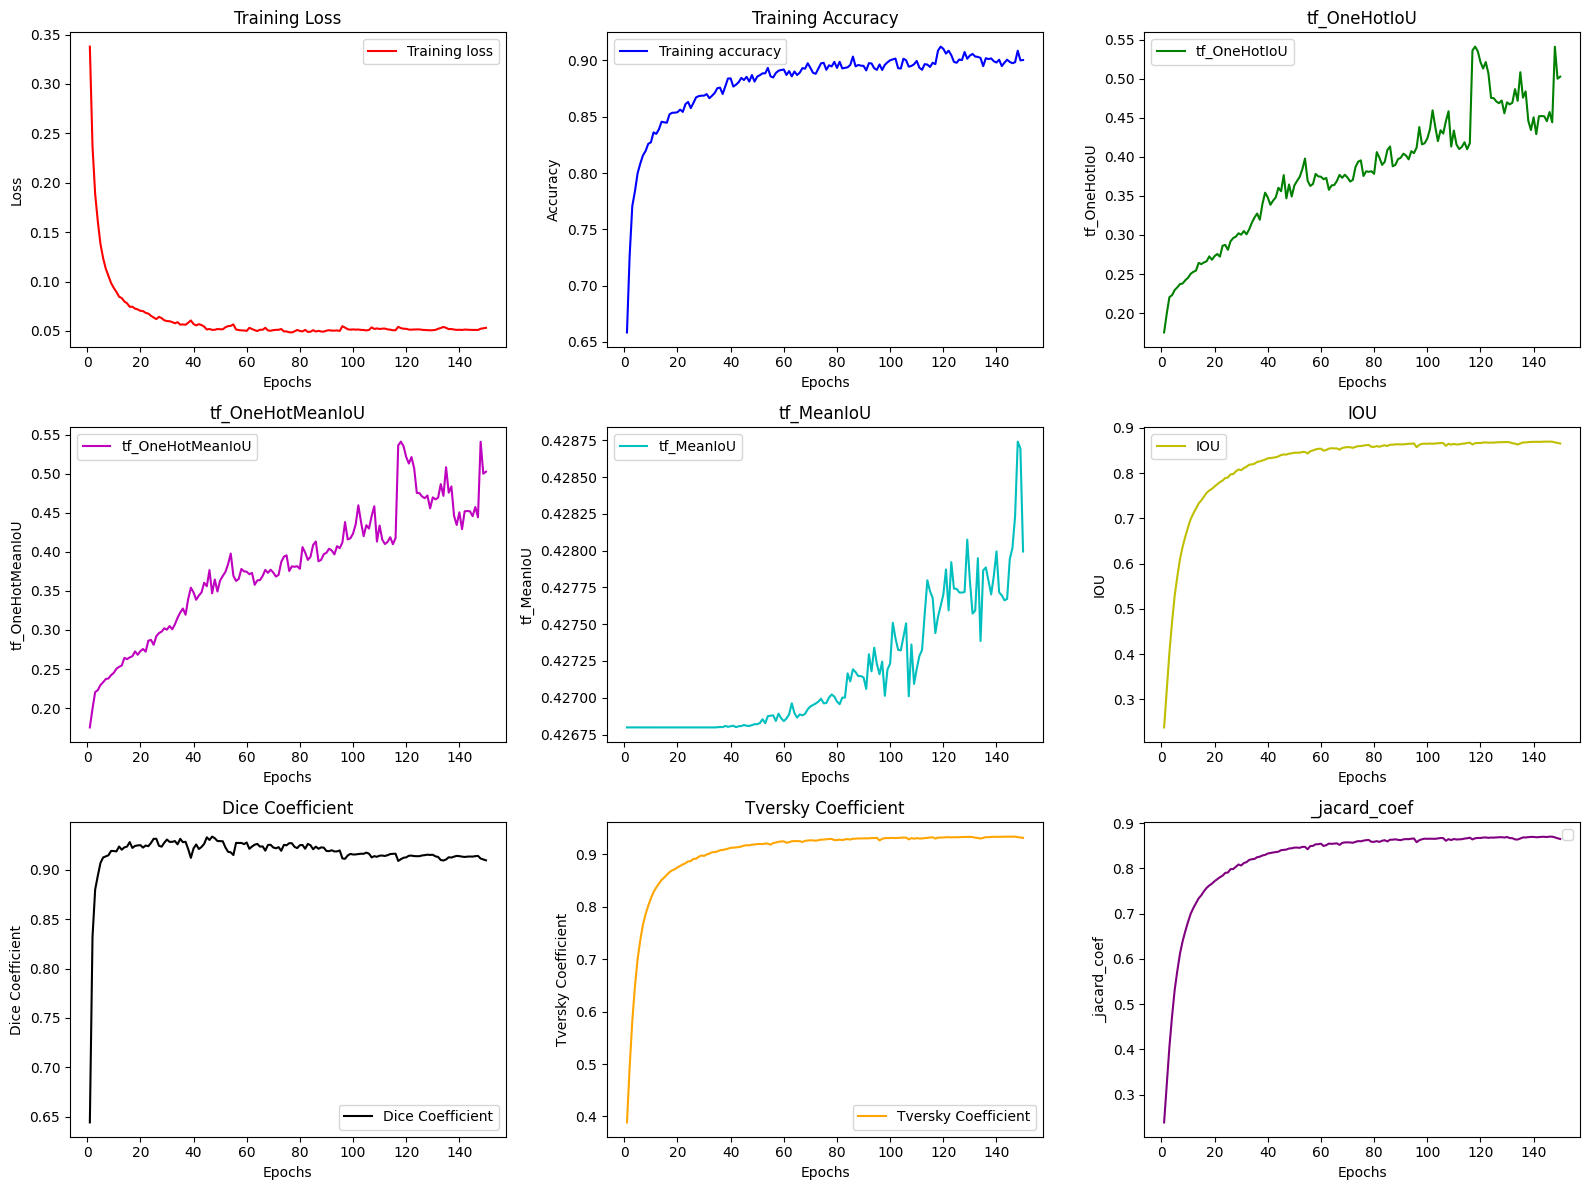

In [63]:
def plot_metrics(metrics_callback):
    # Assuming metrics_callback is an instance of MetricsCallback
    epochs = range(1, len(metrics_callback.losses) + 1)

    plt.figure(figsize=(16, 12))

    # Plot Loss
    plt.subplot(3, 3, 1)
    plt.plot(epochs, metrics_callback.losses, 'r', label='Training loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(3, 3, 2)
    plt.plot(epochs, metrics_callback.accuracies, 'b', label='Training accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot tf_OneHotIoU
    plt.subplot(3, 3, 3)
    plt.plot(epochs, metrics_callback.tf_OneHotIoU, 'g', label='tf_OneHotIoU')
    plt.title('tf_OneHotIoU')
    plt.xlabel('Epochs')
    plt.ylabel('tf_OneHotIoU')
    plt.legend()

    # Plot tf_OneHotMeanIoU
    plt.subplot(3, 3, 4)
    plt.plot(epochs, metrics_callback.tf_OneHotMeanIoU, 'm', label='tf_OneHotMeanIoU')
    plt.title('tf_OneHotMeanIoU')
    plt.xlabel('Epochs')
    plt.ylabel('tf_OneHotMeanIoU')
    plt.legend()

    # Plot tf_MeanIoU
    plt.subplot(3, 3, 5)
    plt.plot(epochs, metrics_callback.tf_MeanIoU, 'c', label='tf_MeanIoU')
    plt.title('tf_MeanIoU')
    plt.xlabel('Epochs')
    plt.ylabel('tf_MeanIoU')
    plt.legend()

    # Plot IOU
    plt.subplot(3, 3, 6)
    plt.plot(epochs, metrics_callback.iou, 'y', label='IOU')
    plt.title('IOU')
    plt.xlabel('Epochs')
    plt.ylabel('IOU')
    plt.legend()

    # Plot Dice Coefficient
    plt.subplot(3, 3, 7)
    plt.plot(epochs, metrics_callback.dice_coeff, 'k', label='Dice Coefficient')
    plt.title('Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coefficient')
    plt.legend()

    # Plot Tversky Coefficient
    plt.subplot(3, 3, 8)
    plt.plot(epochs, metrics_callback.tversky_coeff, 'orange', label='Tversky Coefficient')
    plt.title('Tversky Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Tversky Coefficient')
    plt.legend()

    # Plot _jacard_coef
    plt.subplot(3, 3, 9)
    plt.plot(epochs, metrics_callback._jacard_coef, 'purple', label='_jacard_coef')
    plt.title('_jacard_coef')
    plt.xlabel('Epochs')
    plt.ylabel('_jacard_coef')
    plt.legend()

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()


In [ ]:
try:
  plot_metrics(metrics)
except:
  pass

In [65]:
#IOU
y_pred=model.predict(X_test, batch_size = 16)
y_pred_argmax=np.argmax(y_pred, axis=3)

3/3 [==============================] - 41s 9s/step


In [66]:
y_pred = np.argmax(y_pred, axis=3,keepdims = True)

In [67]:
from keras.utils import to_categorical
y_pred = to_categorical(y_pred, num_classes=6)

In [68]:
dice_coeff = dice_coeff(y_test, y_pred)
print("Dice Coefficient: ", dice_coeff)

Dice Coefficient:  tf.Tensor(0.93828845, shape=(), dtype=float32)


In [69]:
iou_coeff = iou(y_test, y_pred)
print("IoU Coefficient: ", iou_coeff)

IoU Coefficient:  tf.Tensor(
[0.9315345  0.8856839  0.7714587  0.9232022  0.91474694 0.9534121
 0.6981538  0.96926033 0.82297635 0.9395374  0.8874761  0.93859076
 0.83072156 0.79819185 0.8696527  0.8939672  0.88821024 0.7777296
 0.8012037  0.9291749  0.82285047 0.895501   0.8442143  0.8531054
 0.9255755  0.8823259  0.87256414 0.8988787  0.8492882  0.98871154
 0.9840455  0.917014   0.81876206 0.8590982  0.9207221  0.95828605
 0.9301408  0.9209192  0.8641257  0.94922894 0.89025253 0.9336146
 0.9078338  0.8600622 ], shape=(44,), dtype=float32)


In [ ]:
plotMask(y_test[np.argmin(iou_coeff)])
plotMask(y_pred[np.argmin(iou_coeff)])

In [ ]:
plotMask(y_test[np.argmax(iou_coeff)])
plotMask(y_pred[np.argmax(iou_coeff)])